In [33]:
from spec_exam import Gen_spec
from spec_stats import Highest_density_region
from sim_engine import *
from spec_extract import Scale_model
from astropy.table import Table
import pandas as pd
from scipy.interpolate import interp1d, interp2d
from glob import glob
from spec_tools import Source_present, Smooth, Median_w_Error_cont
from spec_id import *
from grizli import multifit
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sea
import fsps
import os
import numpy as np
from scipy.interpolate import RegularGridInterpolator
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)

import dynesty
from dynesty import plotting as dyplot
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 


In [2]:
zlist = glob('../data/posteriors/*zfit*')

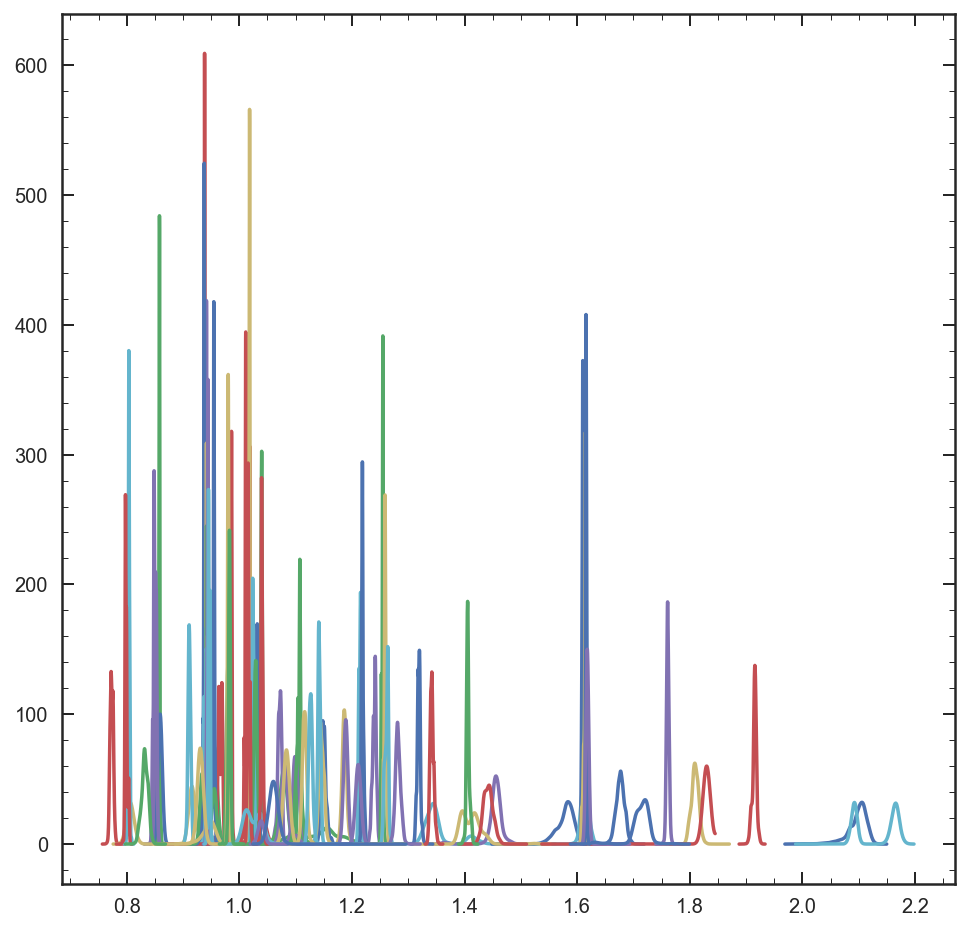

In [3]:
plt.figure(figsize=[8,8])
for i in zlist:
    z,pz = np.load(i)
    plt.plot(z,pz)

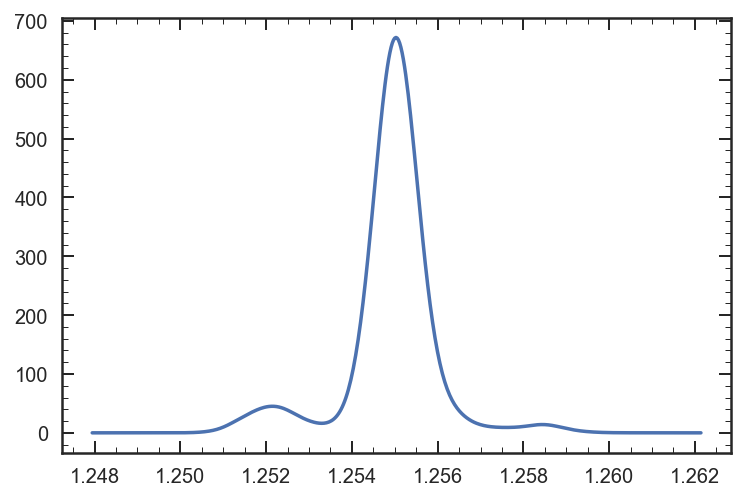

In [9]:
z,pz = np.load('../data/posteriors/GND_21156_zfit_Pz.npy')
plt.plot(z,pz)

In [4]:
select = pd.read_pickle('../spec_files/section.pkl')

In [7]:
tfit = np.zeros(len(select))
zfit = np.zeros(len(select))

for i in select.index:
    z,pz = np.load('../data/posteriors/{0}_{1}_zfit_Pz.npy'.format(select.field[i], select.id[i]))
    zfit[i] = z[pz == max(pz)][0]
    
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(select.field[i], select.id[i]))  
    tfit[i] = z[pz == max(pz)][0]
    

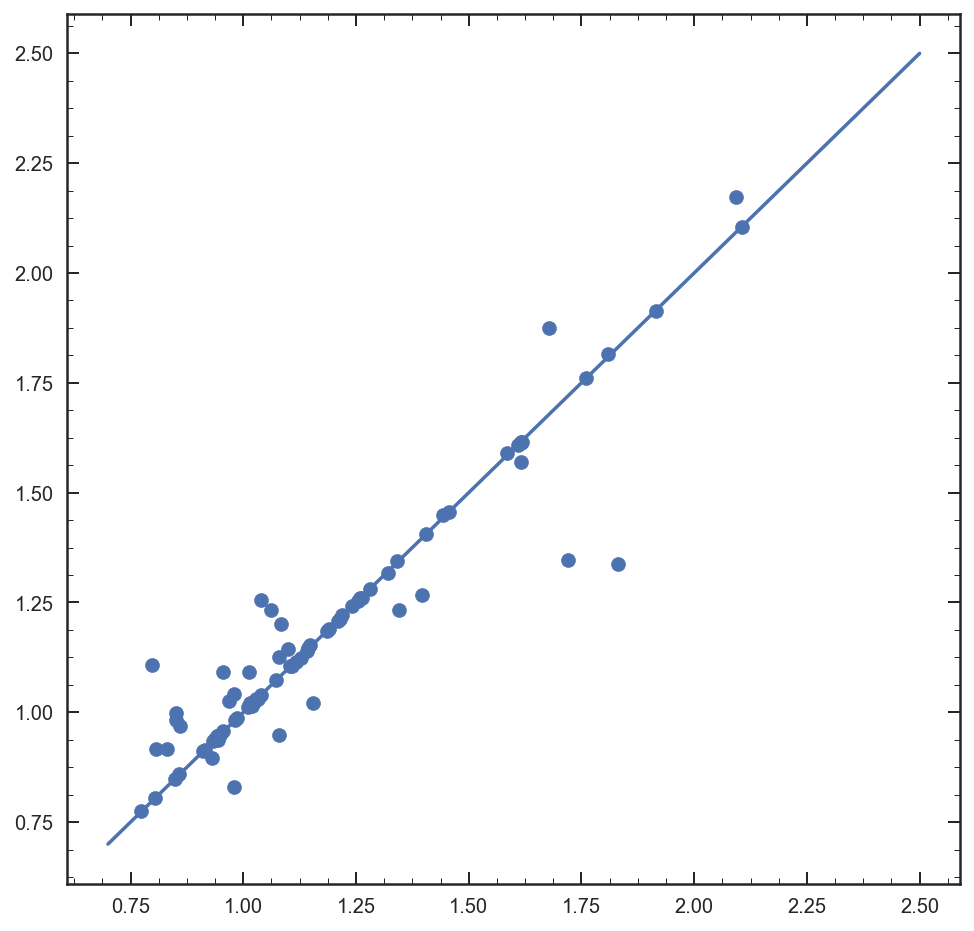

In [9]:
plt.figure(figsize=[8,8])
plt.scatter(zfit,tfit)
plt.plot([0.7,2.5],[0.7,2.5])

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


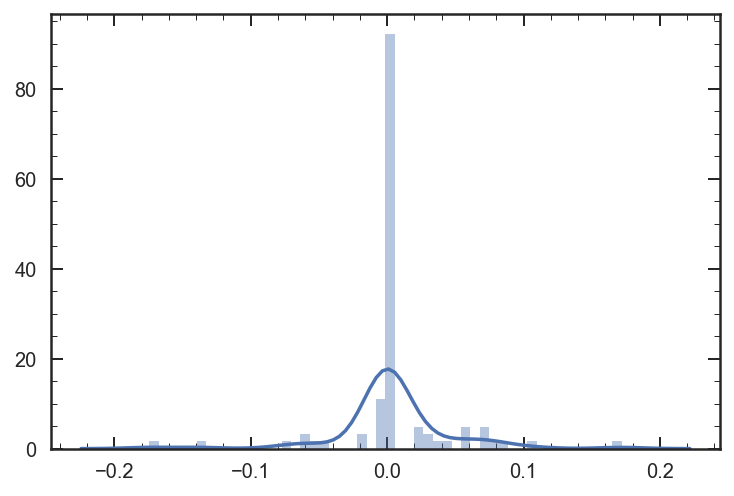

In [11]:
sea.distplot((tfit - zfit) / (1+zfit))

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


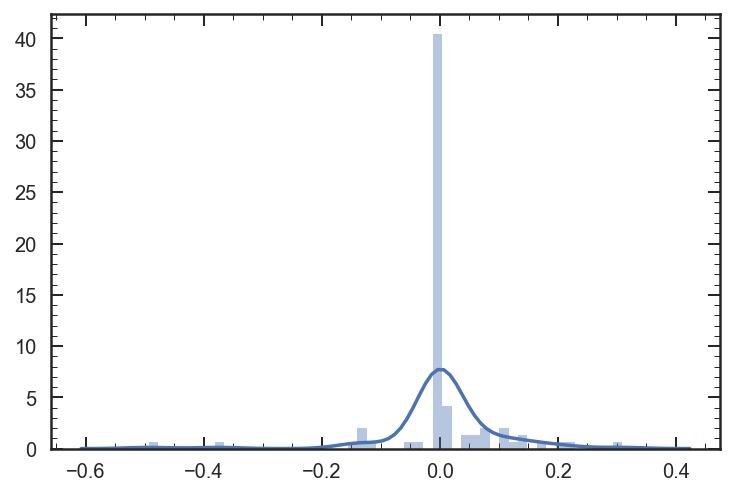

In [12]:
sea.distplot((tfit - zfit))

In [17]:
np.std((tfit - zfit) / (1+zfit)) * (1+2)

0.12334913258425609

In [14]:
np.std((tfit - zfit))

0.09425884032914839

In [21]:
print(np.argmax(np.abs(tfit - zfit)))

74


In [23]:
select.id[74],select.field[74]

(40862, 'GSD')

In [47]:
m, a, z, bsc, rsc, bp1, rp1, ba, bb, bl, ra, rb, rl, logl = np.load('../data/bestfits/GSD_40862_zfit_bfit.npy')

sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = np.log10(1),sfh = 0)
Gs = Gen_spec('GSD',40862, z, g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
    phot_errterm = 0.04, irac_err = 0.08, decontam = True) 
wvs, flxs, errs, beams, trans = Gather_grism_data(Gs)

cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [56]:
a,m

(3.1389852728980907, 0.11183309004773531)

1529.7767668635083


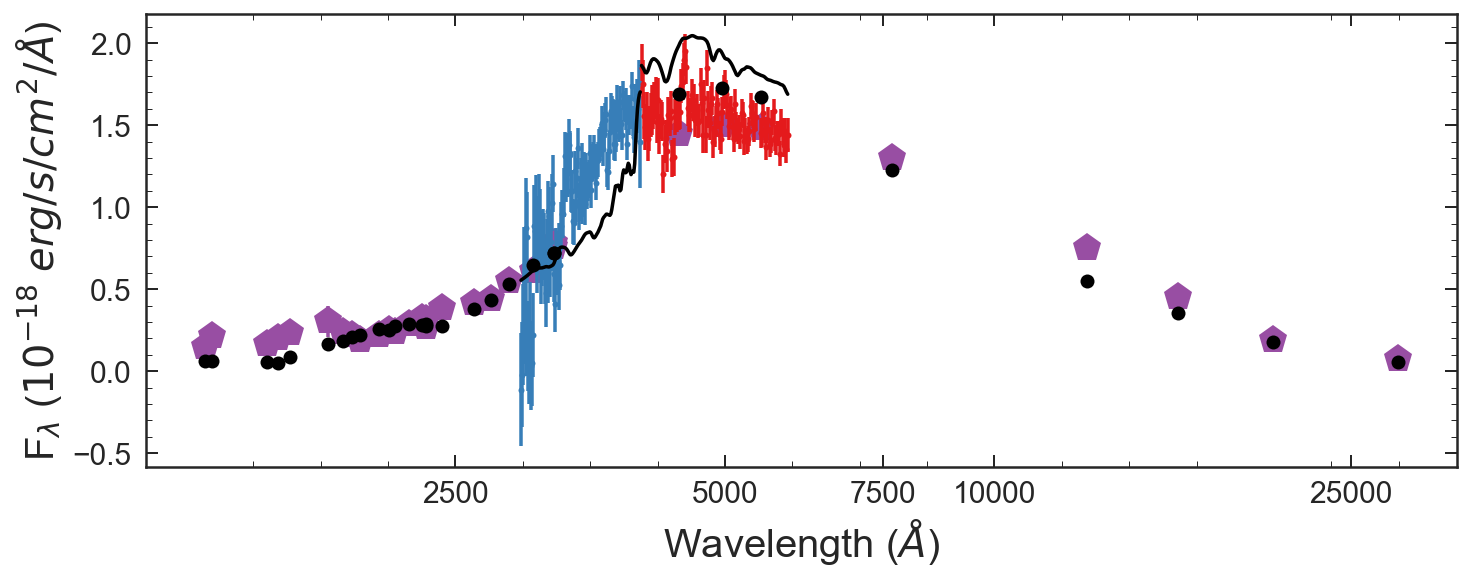

In [50]:
sp.params['logzsol'] = np.log10(m)

wave, flux = sp.get_spectrum(tage = a, peraa = True)    

# if Gs.g102:
#     bcal = Calibrate_grism([Gs.Bwv,Gs.Bfl,Gs.Ber], Gs.Bmfl, bp1)[0]

# if Gs.g141:
#     rcal = Calibrate_grism([Gs.Rwv,Gs.Rfl,Gs.Rer], Gs.Rmfl, rp1)[0]

    
Gmfl, Pmfl = Full_forward_model(Gs, wave, flux, z, wvs, flxs, errs, beams, trans)
              
PC= Full_scale(Gs, Pmfl)
Gmfl = Full_calibrate(PC* Gmfl, [bp1, rp1], [bsc, rsc], wvs)
                      
print(Full_fit_2(Gs, Gmfl, PC*Pmfl, [ba,ra], [bb,rb], [bl, rl], wvs, flxs, errs))
  
gs = GridSpec(3,4, hspace=0.3, wspace = 0.3)   

plt.figure(figsize=[16,15])
###############plot tab##################
plt.subplot(gs[0,:3])

if Gs.g102:
    plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18,Gs.Ber*1E18,
            linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
    plt.plot(np.log10(Gs.Bwv_rf),Gmfl[0]*1E18,'k', zorder = 4)

if Gs.g141:
    plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18,Gs.Rer*1E18,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
    plt.plot(np.log10(Gs.Rwv_rf),Gmfl[1]*1E18,'k', zorder = 4)

plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
        linestyle='None', marker='p', markersize=15, color='#984ea3', zorder = 1)
plt.plot(np.log10(Gs.Pwv_rf),PC*Pmfl*1E18,'ko', zorder = 3)
plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
# plt.title(galaxy, fontsize=25)
plt.xlabel('Wavelength ($\AA$)', fontsize=20)
plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)


In [51]:
print( logl)

1529.7767668635083


In [39]:
np.load('../data/bestfits/GSD_40862_tabfit_bfit.npy')

array([ 1.39220810e+00,  4.48093747e+00,  4.39899397e-04,  6.18707186e-04,
        8.89584006e-04,  5.18661187e-03,  1.61797202e-02,  3.05626160e-02,
        7.65685172e-02,  1.54514007e-01,  2.13360382e-01,  5.01679954e-01,
        1.11461068e+01,  1.33448092e+00,  4.78261744e-01,  9.75334217e-01,
        9.77869633e-01,  4.99797968e-02, -4.39136648e-03,  9.35327395e-01,
        3.39088949e-02,  2.47403417e-02,  1.12423323e+00,  8.51247679e-04,
        5.53752414e-01,  1.89691433e+00,  1.64445229e+03])

In [43]:
z,pz = np.load('../data/posteriors/GSD_40862_zfit_Pz.npy')

zt,pzt = np.load('../data/posteriors/GSD_40862_tabfit_Pz.npy')  


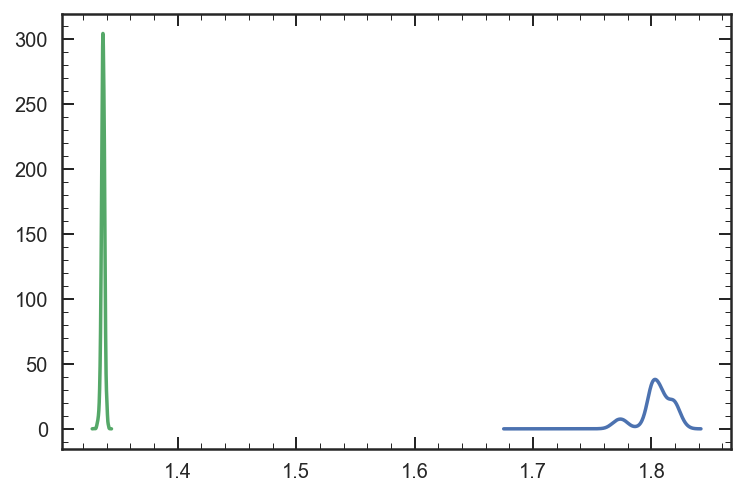

In [44]:
plt.plot(z,pz)
plt.plot(zt,pzt)